In [1]:
!pip install numpy pandas scikit-learn tensorflow keras gym


In [2]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd

# Load and preprocess dataset
data = pd.read_csv("C:/Users/srini/DRL_Project/ecommerce_customer_data_large.csv")

# Preprocessing
relevant_columns = ['Customer Age', 'Product Category', 'Product Price', 'Gender']
data_subset = data[relevant_columns]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_columns = encoder.fit_transform(data_subset[['Product Category', 'Gender']])
numerical_features = data_subset[['Customer Age', 'Product Price']].values

state_representation = np.hstack((numerical_features, encoded_columns))

# Normalize product price for better training
scaler = MinMaxScaler()
state_representation[:, 1:2] = scaler.fit_transform(state_representation[:, 1:2])

actions = encoder.categories_[0]
action_size = len(actions)
state_size = state_representation.shape[1]


C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Parameters
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.0005
batch_size = 64
memory = deque(maxlen=5000)  # Replay buffer

# Reward function
def calculate_reward(action_type):
    rewards = {'click': 2, 'add_to_cart': 5, 'purchase': 15}
    penalties = {'no_action': -1}
    return rewards.get(action_type, penalties.get(action_type, 0))

# Build DQN model
def build_dqn(state_size, action_size):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(state_size,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(action_size, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Initialize DQN
dqn_model = build_dqn(state_size, action_size)


C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Choose action with epsilon-greedy strategy
def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)  # Exploration
    q_values = dqn_model.predict(np.array([state]), verbose=0)
    return np.argmax(q_values[0])  # Exploitation

# Train DQN
def train_dqn(dqn_model, memory, batch_size):
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            target += gamma * np.amax(dqn_model.predict(np.array([next_state]), verbose=0)[0])
        target_f = dqn_model.predict(np.array([state]), verbose=0)
        target_f[0][action] = target
        dqn_model.fit(np.array([state]), target_f, epochs=1, verbose=0)

# Simulate an episode
def simulate_episode(memory, state_representation, epsilon, max_steps=200):
    state = random.choice(state_representation)
    total_reward = 0
    for _ in range(max_steps):
        action = choose_action(state, epsilon)
        reward_type = random.choice(['click', 'add_to_cart', 'purchase', 'no_action'])
        reward = calculate_reward(reward_type)
        next_state = random.choice(state_representation)
        done = random.choice([True, False])
        memory.append((state, action, reward, next_state, done))
        total_reward += reward
        state = next_state
        if done:
            break
    return total_reward


In [5]:
# Initialize histories for metrics
reward_history_100 = []
exploration_history_100 = []
reward_history_500 = []
exploration_history_500 = []

# Train for 100 Episodes
print("Training for 100 episodes...")
for episode in range(100):
    total_reward = simulate_episode(memory, state_representation, epsilon)
    train_dqn(dqn_model, memory, batch_size)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    reward_history_100.append(total_reward)
    exploration_history_100.append(epsilon)
    print(f"Episode {episode + 1}/100, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

# Save the model after 100 episodes
dqn_model.save("dqn_recommendation_model_100.keras")
print("Training after 100 episodes complete. Model saved as 'dqn_recommendation_model_100.keras'.")

# Train for additional 400 Episodes (Total 500)
print("Training for additional 400 episodes (500 total)...")
for episode in range(400):
    total_reward = simulate_episode(memory, state_representation, epsilon)
    train_dqn(dqn_model, memory, batch_size)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    reward_history_500.append(total_reward)
    exploration_history_500.append(epsilon)
    print(f"Episode {episode + 1}/400, Total Reward: {total_reward}")

# Save the model after 500 episodes
dqn_model.save("dqn_recommendation_model_500.keras")
print("Training after 500 episodes complete. Model saved as 'dqn_recommendation_model_500.keras'.")

# Combine histories for analysis
full_reward_history = reward_history_100 + reward_history_500
full_exploration_history = exploration_history_100 + exploration_history_500


Training for 100 episodes...
Episode 1/100, Total Reward: -1, Epsilon: 0.99
Episode 2/100, Total Reward: 79, Epsilon: 0.99
Episode 3/100, Total Reward: 26, Epsilon: 0.99
Episode 4/100, Total Reward: 1, Epsilon: 0.98
Episode 5/100, Total Reward: 13, Epsilon: 0.98
Episode 6/100, Total Reward: 2, Epsilon: 0.97
Episode 7/100, Total Reward: 7, Epsilon: 0.97
Episode 8/100, Total Reward: -1, Epsilon: 0.96
Episode 9/100, Total Reward: -1, Epsilon: 0.96
Episode 10/100, Total Reward: 7, Epsilon: 0.95
Episode 11/100, Total Reward: 9, Epsilon: 0.95
Episode 12/100, Total Reward: 34, Epsilon: 0.94
Episode 13/100, Total Reward: 20, Epsilon: 0.94
Episode 14/100, Total Reward: -1, Epsilon: 0.93
Episode 15/100, Total Reward: 30, Epsilon: 0.93
Episode 16/100, Total Reward: 5, Epsilon: 0.92
Episode 17/100, Total Reward: 2, Epsilon: 0.92
Episode 18/100, Total Reward: 12, Epsilon: 0.91
Episode 19/100, Total Reward: 4, Epsilon: 0.91
Episode 20/100, Total Reward: 19, Epsilon: 0.90
Episode 21/100, Total Reward

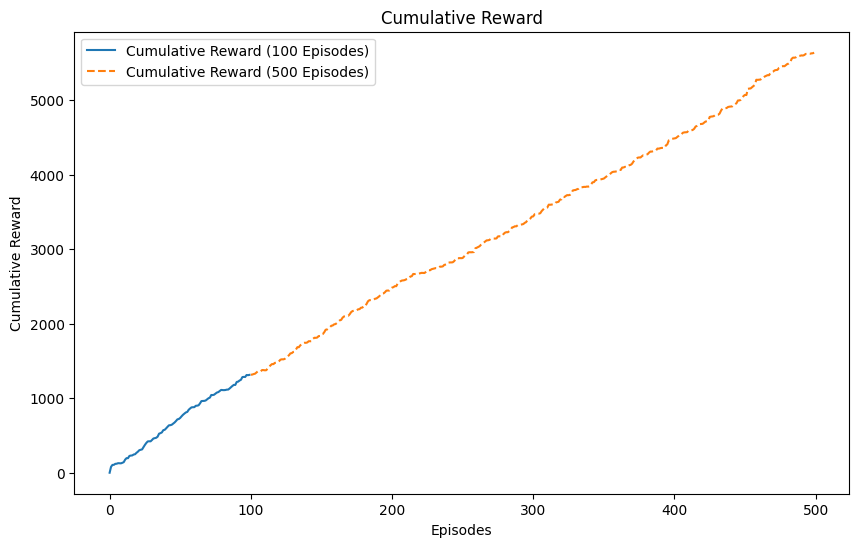

In [6]:
# Plot cumulative reward for 100 and 500 episodes
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(reward_history_100), label="Cumulative Reward (100 Episodes)")
plt.plot(range(len(reward_history_100), len(full_reward_history)), 
         np.cumsum(reward_history_500) + np.cumsum(reward_history_100)[-1], 
         label="Cumulative Reward (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward")
plt.legend()
plt.show()


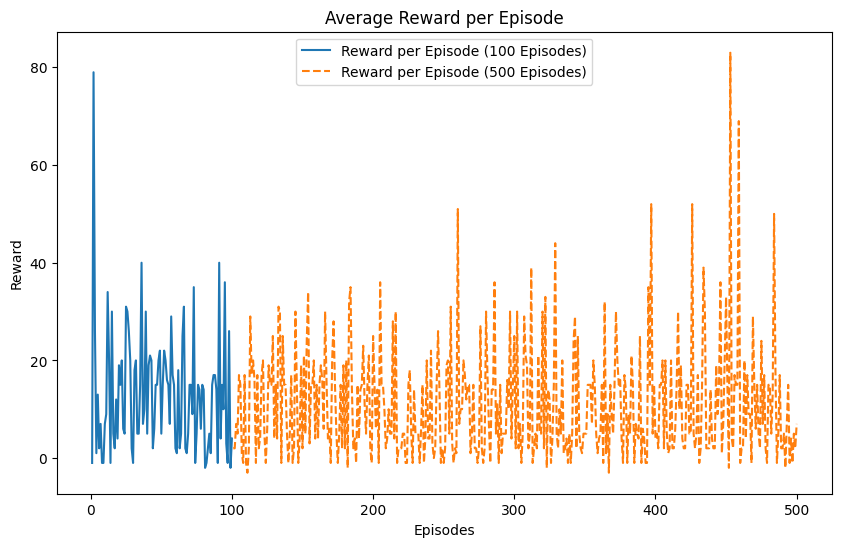

In [7]:
# Compute average reward for each episode
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history_100) + 1), reward_history_100, label="Reward per Episode (100 Episodes)")
plt.plot(range(len(reward_history_100) + 1, len(full_reward_history) + 1), reward_history_500, label="Reward per Episode (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Average Reward per Episode")
plt.legend()
plt.show()


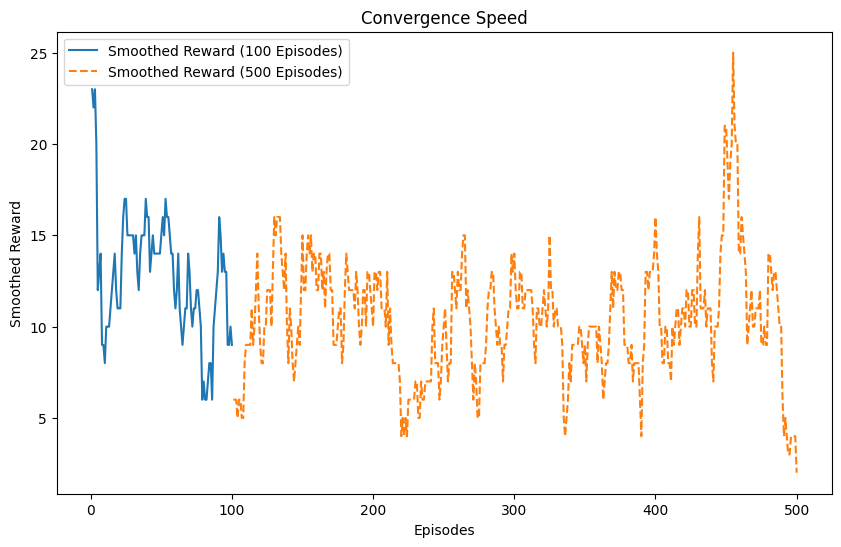

In [8]:
# Smooth rewards for convergence speed plot
from scipy.ndimage import uniform_filter1d

smoothed_rewards_100 = uniform_filter1d(reward_history_100, size=10)
smoothed_rewards_500 = uniform_filter1d(reward_history_500, size=10)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(smoothed_rewards_100) + 1), smoothed_rewards_100, label="Smoothed Reward (100 Episodes)")
plt.plot(range(len(smoothed_rewards_100) + 1, len(full_reward_history) + 1), smoothed_rewards_500, label="Smoothed Reward (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Smoothed Reward")
plt.title("Convergence Speed")
plt.legend()
plt.show()


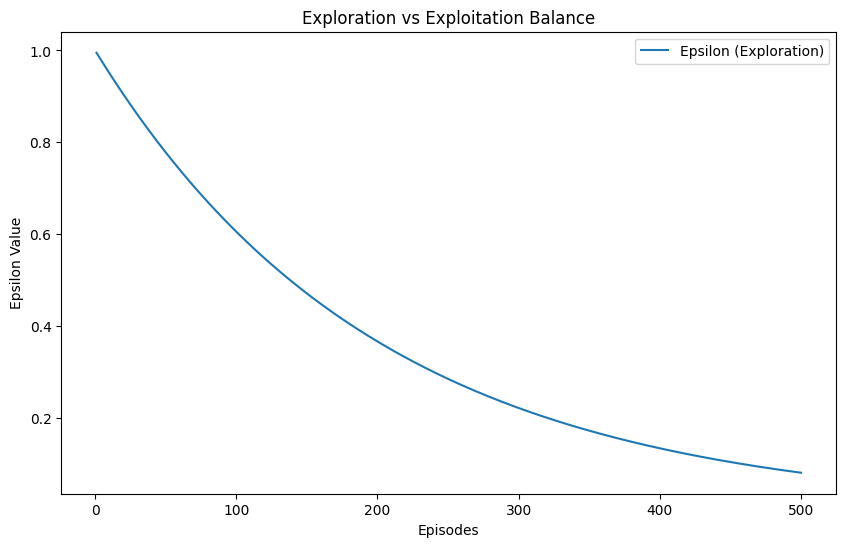

In [9]:
# Plot Exploration vs Exploitation Balance (Epsilon)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(full_exploration_history) + 1), full_exploration_history, label="Epsilon (Exploration)")
plt.xlabel("Episodes")
plt.ylabel("Epsilon Value")
plt.title("Exploration vs Exploitation Balance")
plt.legend()
plt.show()


In [ ]:
# Evaluation Function
def evaluate_dqn_model(dqn_model, state_representation, episodes=100, max_steps=200):
    total_rewards = []
    total_clicks = 0
    total_add_to_cart = 0
    total_purchases = 0
    total_users = episodes
    total_engagements = 0
    total_revenue = 0

    for episode in range(episodes):
        state = random.choice(state_representation)
        episode_reward = 0
        for _ in range(max_steps):
            # Exploitation only (epsilon = 0)
            action = choose_action(state, epsilon=0)
            reward_type = random.choice(['click', 'add_to_cart', 'purchase', 'no_action'])
            reward = calculate_reward(reward_type)

            # Engagement and revenue metrics
            if reward_type == 'click':
                total_clicks += 1
                total_engagements += 1
            elif reward_type == 'add_to_cart':
                total_add_to_cart += 1
                total_engagements += 1
            elif reward_type == 'purchase':
                total_purchases += 1
                total_engagements += 1
                total_revenue += 15  # Assume $15 revenue per purchase

            episode_reward += reward
            state = random.choice(state_representation)

            if random.choice([True, False]):  # Simulate terminal state
                break

        total_rewards.append(episode_reward)

    # Metrics calculation
    cumulative_reward = sum(total_rewards)
    avg_reward = cumulative_reward / episodes
    ctr = total_clicks / total_users
    engagement_rate = total_engagements / total_users
    rpu = total_revenue / total_users

    metrics = {
        "Cumulative Reward": cumulative_reward,
        "Average Reward per Episode": avg_reward,
        "Click-Through Rate (CTR)": ctr,
        "Engagement Rate": engagement_rate,
        "Revenue Per User (RPU)": rpu
    }

    return metrics


In [ ]:
# Evaluate after 100 episodes
print("Evaluating DQN model after 100 episodes...")
metrics_100 = evaluate_dqn_model(dqn_model, state_representation, episodes=100)
for metric, value in metrics_100.items():
    print(f"{metric}: {value:.2f}")

# Evaluate after 500 episodes
print("\nEvaluating DQN model after 500 episodes...")
metrics_500 = evaluate_dqn_model(dqn_model, state_representation, episodes=500)
for metric, value in metrics_500.items():
    print(f"{metric}: {value:.2f}")


Evaluating DQN model after 100 episodes...
Cumulative Reward: 983.00
Average Reward per Episode: 9.83
Click-Through Rate (CTR): 0.46
Engagement Rate: 1.32
Revenue Per User (RPU): 7.65

Evaluating DQN model after 500 episodes...
Cumulative Reward: 5411.00
Average Reward per Episode: 10.82
Click-Through Rate (CTR): 0.51
Engagement Rate: 1.53
Revenue Per User (RPU): 7.74


: 

DQN with Colaborative Filtering

C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training for 100 episodes...
Episode 1/100, Total Reward: 5, Epsilon: 0.99
Episode 2/100, Total Reward: 5, Epsilon: 0.99
Episode 3/100, Total Reward: -1, Epsilon: 0.99
Episode 4/100, Total Reward: 20, Epsilon: 0.98
Episode 5/100, Total Reward: 27, Epsilon: 0.98
Episode 6/100, Total Reward: -1, Epsilon: 0.97
Episode 7/100, Total Reward: 9, Epsilon: 0.97
Episode 8/100, Total Reward: 5, Epsilon: 0.96
Episode 9/100, Total Reward: 40, Epsilon: 0.96
Episode 10/100, Total Reward: 7, Epsilon: 0.95
Episode 11/100, Total Reward: 5, Epsilon: 0.95
Episode 12/100, Total Reward: 5, Epsilon: 0.94
Episode 13/100, Total Reward: 2, Epsilon: 0.94
Episode 14/100, Total Reward: 2, Epsilon: 0.93
Episode 15/100, Total Reward: 5, Epsilon: 0.93
Episode 16/100, Total Reward: -1, Epsilon: 0.92
Episode 17/100, Total Reward: 26, Epsilon: 0.92
Episode 18/100, Total Reward: 2, Epsilon: 0.91
Episode 19/100, Total Reward: 4, Epsilon: 0.91
Episode 20/100, Total Reward: -1, Epsilon: 0.90
Episode 21/100, Total Reward: 10

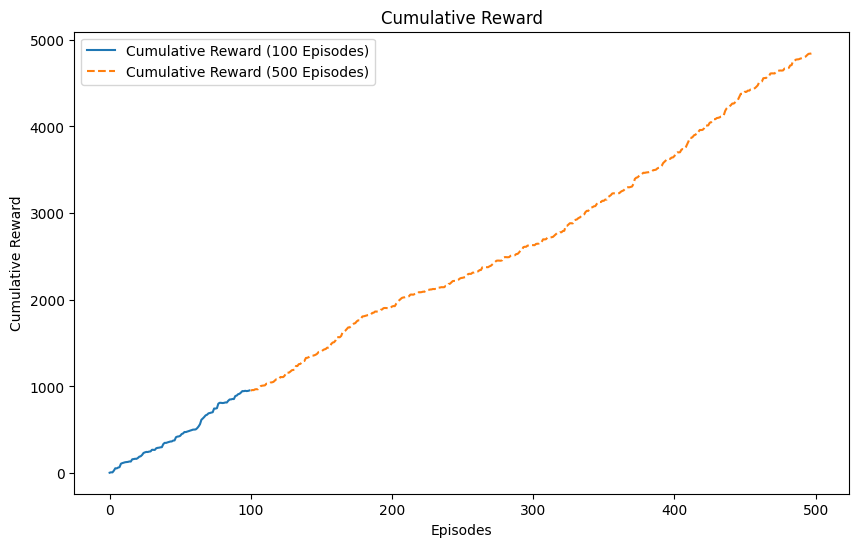

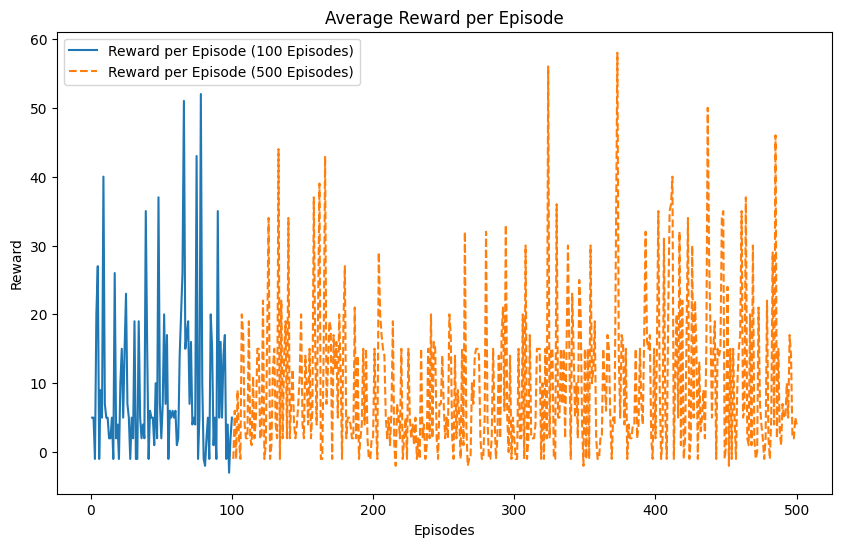

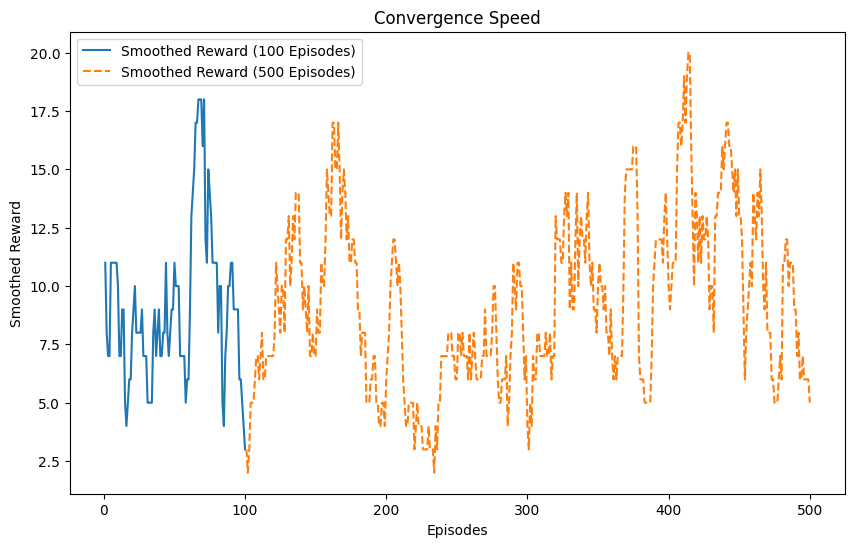

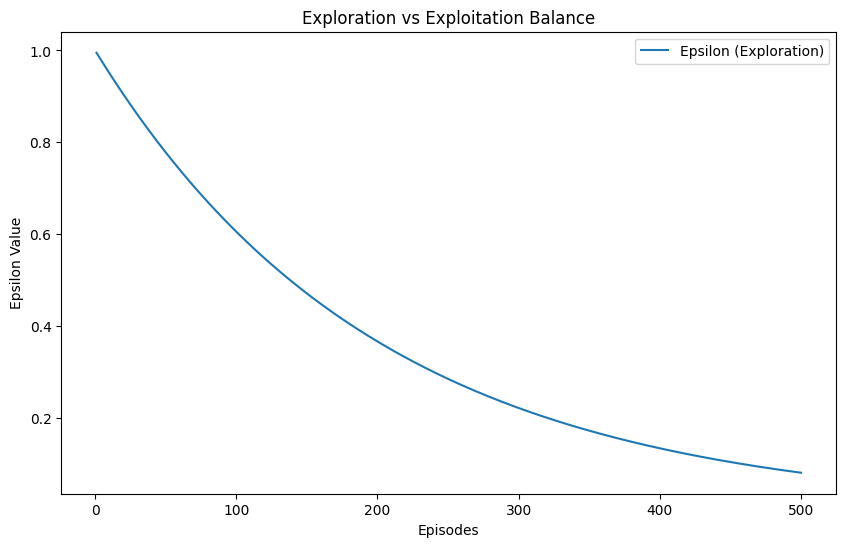

In [11]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd

# Load and preprocess dataset
data = pd.read_csv("C:/Users/srini/DRL_Project/ecommerce_customer_data_large.csv")

# Preprocessing
relevant_columns = ['Customer Age', 'Product Category', 'Product Price', 'Gender']
data_subset = data[relevant_columns]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_columns = encoder.fit_transform(data_subset[['Product Category', 'Gender']])
numerical_features = data_subset[['Customer Age', 'Product Price']].values

# Add Collaborative Filtering (CF) Features
user_embeddings = np.random.rand(len(data_subset), 8)  # Example user embeddings (random for simplicity)
item_embeddings = np.random.rand(len(data_subset), 8)  # Example item embeddings (random for simplicity)

# State representation with CF features
state_representation = np.hstack((numerical_features, encoded_columns, user_embeddings, item_embeddings))

# Normalize numerical features
scaler = MinMaxScaler()
state_representation[:, 1:2] = scaler.fit_transform(state_representation[:, 1:2])

actions = encoder.categories_[0]
action_size = len(actions)
state_size = state_representation.shape[1]

# Parameters
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.0005
batch_size = 64
memory = deque(maxlen=5000)

# Reward function
def calculate_reward(action_type):
    rewards = {'click': 2, 'add_to_cart': 5, 'purchase': 15}
    penalties = {'no_action': -1}
    return rewards.get(action_type, penalties.get(action_type, 0))

# Build DQN model
def build_dqn(state_size, action_size):
    model = tf.keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(state_size,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(action_size, activation='linear')  # Linear output for Q-values
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Initialize DQN
dqn_model = build_dqn(state_size, action_size)

# Choose action with epsilon-greedy strategy
def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)  # Exploration
    q_values = dqn_model.predict(np.array([state]), verbose=0)
    return np.argmax(q_values[0])  # Exploitation

# Train DQN
def train_dqn(dqn_model, memory, batch_size):
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            target += gamma * np.amax(dqn_model.predict(np.array([next_state]), verbose=0)[0])
        target_f = dqn_model.predict(np.array([state]), verbose=0)
        target_f[0][action] = target
        dqn_model.fit(np.array([state]), target_f, epochs=1, verbose=0)

# Simulate an episode
def simulate_episode(memory, state_representation, epsilon, max_steps=200):
    state = random.choice(state_representation)
    total_reward = 0
    for _ in range(max_steps):
        action = choose_action(state, epsilon)
        reward_type = random.choice(['click', 'add_to_cart', 'purchase', 'no_action'])
        reward = calculate_reward(reward_type)
        next_state = random.choice(state_representation)
        done = random.choice([True, False])
        memory.append((state, action, reward, next_state, done))
        total_reward += reward
        state = next_state
        if done:
            break
    return total_reward

# Train and track metrics
reward_history_100 = []
exploration_history_100 = []
reward_history_500 = []
exploration_history_500 = []

print("Training for 100 episodes...")
for episode in range(100):
    total_reward = simulate_episode(memory, state_representation, epsilon)
    train_dqn(dqn_model, memory, batch_size)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    reward_history_100.append(total_reward)
    exploration_history_100.append(epsilon)
    print(f"Episode {episode + 1}/100, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

# Save model after 100 episodes
dqn_model.save("dqn_cf_model_100.keras")
print("Model saved as 'dqn_cf_model_100.keras'.")

print("Training for additional 400 episodes...")
for episode in range(400):
    total_reward = simulate_episode(memory, state_representation, epsilon)
    train_dqn(dqn_model, memory, batch_size)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    reward_history_500.append(total_reward)
    exploration_history_500.append(epsilon)
    print(f"Episode {episode + 1}/400, Total Reward: {total_reward}")

# Save model after 500 episodes
dqn_model.save("dqn_cf_model_500.keras")
print("Model saved as 'dqn_cf_model_500.keras'.")

# Combine histories for analysis
full_reward_history = reward_history_100 + reward_history_500
full_exploration_history = exploration_history_100 + exploration_history_500

# Cumulative reward
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(reward_history_100), label="Cumulative Reward (100 Episodes)")
plt.plot(range(len(reward_history_100), len(full_reward_history)), 
         np.cumsum(reward_history_500) + np.cumsum(reward_history_100)[-1], 
         label="Cumulative Reward (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward")
plt.legend()
plt.show()

# Average reward per episode
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history_100) + 1), reward_history_100, label="Reward per Episode (100 Episodes)")
plt.plot(range(len(reward_history_100) + 1, len(full_reward_history) + 1), reward_history_500, label="Reward per Episode (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Average Reward per Episode")
plt.legend()
plt.show()

# Convergence speed (smoothed reward over episodes)
from scipy.ndimage import uniform_filter1d

smoothed_rewards_100 = uniform_filter1d(reward_history_100, size=10)
smoothed_rewards_500 = uniform_filter1d(reward_history_500, size=10)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(smoothed_rewards_100) + 1), smoothed_rewards_100, label="Smoothed Reward (100 Episodes)")
plt.plot(range(len(smoothed_rewards_100) + 1, len(full_reward_history) + 1), smoothed_rewards_500, label="Smoothed Reward (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Smoothed Reward")
plt.title("Convergence Speed")
plt.legend()
plt.show()

# Exploration vs Exploitation Balance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(full_exploration_history) + 1), full_exploration_history, label="Epsilon (Exploration)")
plt.xlabel("Episodes")
plt.ylabel("Epsilon Value")
plt.title("Exploration vs Exploitation Balance")
plt.legend()
plt.show()


In [12]:
# Evaluation Function
def evaluate_dqn_model(dqn_model, state_representation, episodes=100, max_steps=200):
    total_rewards = []
    total_clicks = 0
    total_add_to_cart = 0
    total_purchases = 0
    total_users = episodes
    total_engagements = 0
    total_revenue = 0

    for episode in range(episodes):
        state = random.choice(state_representation)
        episode_reward = 0
        for _ in range(max_steps):
            # Exploitation only (epsilon = 0)
            action = choose_action(state, epsilon=0)
            reward_type = random.choice(['click', 'add_to_cart', 'purchase', 'no_action'])
            reward = calculate_reward(reward_type)

            # Engagement and revenue metrics
            if reward_type == 'click':
                total_clicks += 1
                total_engagements += 1
            elif reward_type == 'add_to_cart':
                total_add_to_cart += 1
                total_engagements += 1
            elif reward_type == 'purchase':
                total_purchases += 1
                total_engagements += 1
                total_revenue += 15  # Assume $15 revenue per purchase

            episode_reward += reward
            state = random.choice(state_representation)

            if random.choice([True, False]):  # Simulate terminal state
                break

        total_rewards.append(episode_reward)

    # Metrics calculation
    cumulative_reward = sum(total_rewards)
    avg_reward = cumulative_reward / episodes
    ctr = total_clicks / total_users
    engagement_rate = total_engagements / total_users
    rpu = total_revenue / total_users

    metrics = {
        "Cumulative Reward": cumulative_reward,
        "Average Reward per Episode": avg_reward,
        "Click-Through Rate (CTR)": ctr,
        "Engagement Rate": engagement_rate,
        "Revenue Per User (RPU)": rpu
    }

    return metrics


In [13]:
# Evaluate after 100 episodes
print("Evaluating DQN model after 100 episodes...")
metrics_100 = evaluate_dqn_model(dqn_model, state_representation, episodes=100)
for metric, value in metrics_100.items():
    print(f"{metric}: {value:.2f}")

# Evaluate after 500 episodes
print("\nEvaluating DQN model after 500 episodes...")
metrics_500 = evaluate_dqn_model(dqn_model, state_representation, episodes=500)
for metric, value in metrics_500.items():
    print(f"{metric}: {value:.2f}")


Evaluating DQN model after 100 episodes...
Cumulative Reward: 1057.00
Average Reward per Episode: 10.57
Click-Through Rate (CTR): 0.45
Engagement Rate: 1.47
Revenue Per User (RPU): 7.50

Evaluating DQN model after 500 episodes...
Cumulative Reward: 5509.00
Average Reward per Episode: 11.02
Click-Through Rate (CTR): 0.49
Engagement Rate: 1.50
Revenue Per User (RPU): 8.19
